# Collaboration and Competition Project Report

---

### 1.Examination of State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
This yields a single score for each episode.
The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

### 2. Algorithm

Algorithm is DDPG. DDPG algorithm uses two seperate network which are working collaboratively; actor and critic. Actor network does policiy approximation where critic does value estimation. Training of this network composed out of two steps; acting and learning. In acting step, agent gives state vector as an input to Actor network and receives actions to be taken. In learning step, Critic network evaluates correctness of action taken and gives feed to Actor network so Actor network adjust its weights accordingly.

DDPG is used for multi-agent system. It is adapted to simultaneously train both agents through self-play. Each agent used the same actor network to select actions, and the experience was added to a shared replay buffer.

In [7]:
from model import Actor, Critic
from agent import Agent

import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import time
from collections import namedtuple, deque
from typing import NamedTuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Config(NamedTuple):
    num_workers: int = 2
    episode_count: int = 10000
    buffer_size = int(1e5)  
    mini_batch_size: int = 1024
        
class DeviceConfig:
    DEVICE = torch.device('cpu')

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DeviceConfig.device = device

config = Config(num_workers=num_agents)

### 3. Networks

#### Actor Network

input size = 24 output size = 2. One hidden layers and one output layer each hidden layer has 256 hidden units and is followed by a ReLU activation layer. A batch normalization layer after the first layer Output layer is followed by a tanh activation layer

#### Critic Network

input size = 33 output size = 1. One hidden layers and one output layer each hidden layer has 256 hidden units and is followed by a ReLU activation layer A batch normalization layer after the first layer. Output layer is followed no activation unit

#### Hyperparameters

Mini batch size = 1024
Tau = 0.001
Gamma = 0.99
Learning rate of actor = 0.001
Learning rate of critic = 0.001
Weight decay = 0
Epsilon minimum = 0.1
Epsilon maximum = 1.0

In [10]:
def ddpg(agent, max_step=10000, train_mode=True):
    scores_window = deque(maxlen=100)
    scores = []
        
    for i in range(1, config.episode_count+1):
        begin = time.time()
        
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_run = np.zeros(num_agents)

        for t in range(max_step): 
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations 
            rewards = env_info.rewards
            dones = env_info.local_done
            if train_mode:
                agent.step(states, actions, rewards, next_states, dones)

            states = next_states
            scores_run += rewards 
            if np.any(dones):
                break

        score = np.mean(scores_run)

        scores_window.append(score)
        score_average = np.mean(scores_window)
        scores.append(score)
        
        if i % 50 == 0:
            print('\rEpisode {} Average score: {:.2f} Min: {:.2f} Max: {:.2f} Time: {:.2f} Epsilon: {:.2f}'.format(
                i, 
                score_average, 
                np.min(scores), 
                np.max(scores), 
                time.time() - begin,
                agent.epsilon
            ))        
                    
        if score_average >= 0.5:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nSolve in {:d} episodes. Average score: {:.2f}'.format(i, score_average))            
            break            
            
    return scores

In [17]:
rand_seed = 0
agent = Agent(config=config,
              state_size=state_size, 
              action_size=action_size, 
              num_agents=num_agents, 
              random_seed=rand_seed,
              device=device)

scores = ddpg(agent)

Episode 50 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.36 Epsilon: 1.00
Episode 100 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.37 Epsilon: 1.00
Episode 150 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.36 Epsilon: 1.00
Episode 200 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.37 Epsilon: 1.00
Episode 250 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.36 Epsilon: 1.00
Episode 300 Average score: 0.00 Min: -0.00 Max: 0.05 Time: 1.04 Epsilon: 1.00
Episode 350 Average score: 0.00 Min: -0.00 Max: 0.05 Time: 0.37 Epsilon: 1.00
Episode 400 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.37 Epsilon: 1.00
Episode 450 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.36 Epsilon: 1.00
Episode 500 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.37 Epsilon: 1.00
Episode 550 Average score: -0.00 Min: -0.00 Max: 0.15 Time: 0.37 Epsilon: 1.00
Episode 600 Average score: 0.00 Min: -0.00 Max: 0.15 Time: 0.37 Epsilon: 1.00
Episode 650 Average score: 0.01 Min: -0.00 Max: 0.15 Tim

### 4. Plot of Rewards

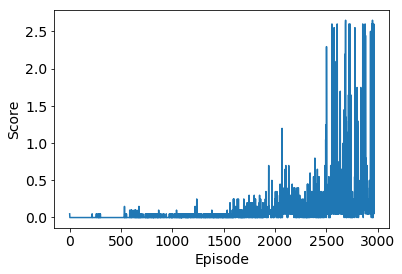

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [19]:
rand_seed = 0
agent = Agent(config=config,
              state_size=state_size, 
              action_size=action_size, 
              num_agents=num_agents, 
              random_seed=rand_seed,
              device=torch.device('cpu'),
              actor_trained_weight_filename="checkpoint_actor.pth", 
              critic_trained_weight_filename="checkpoint_critic.pth")

scores_test = ddpg(agent, train_mode=False)


Solve in 1 episodes. Average score: 2.65


In [20]:
env.close()

### Future Work

MADDPG is a efficiently working network for such two agent problem. Some further tricks can be investigated using different environments to see what could be fallbacks of this network to improve it. Without doing such a research we could better train it. Training duration is long, high number of episode is required. Weights could be cleverly initialized like transfer learning so convergence can be fasten.